# **Image Classification for Maize Disease Detection Using Transfer Learning**

## **Data Ingestion**

In [1]:
import kagglehub
smaranjitghose_corn_or_maize_leaf_disease_dataset_path = kagglehub.dataset_download('smaranjitghose/corn-or-maize-leaf-disease-dataset')

print('Data source import complete.')


Data source import complete.


In [2]:
import os

data_path = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data"
images_list = []
for dir_paths, dir_name, filenames in os.walk(data_path):
    if len(filenames) > 0:
        for filename in filenames:
            images_list.append(dir_paths + "/" + filename)

images_list[:5]

['/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (454).JPG',
 '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (365).JPG',
 '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (585).JPG',
 '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1171).JPG',
 '/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1181).JPG']

Disease:  Common_Rust
Dimension:  256 by 256


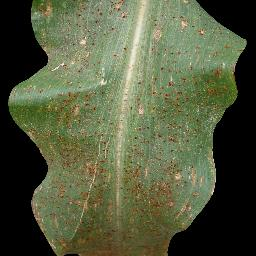



Disease:  Common_Rust
Dimension:  256 by 256


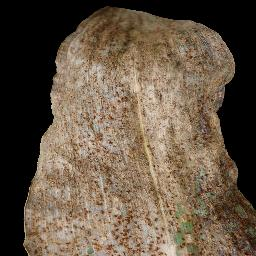



Disease:  Common_Rust
Dimension:  256 by 256


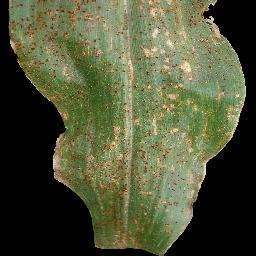



Disease:  Gray_Leaf_Spot
Dimension:  256 by 256


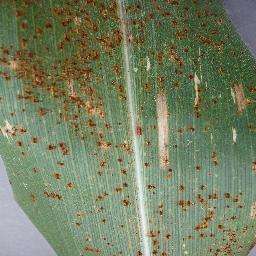



Disease:  Blight
Dimension:  256 by 256


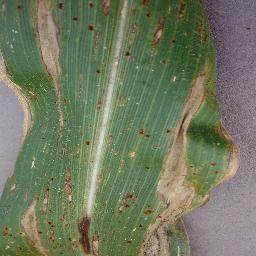

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image

#random.seed(42)
for i in range(5):
    image_path = random.choice(images_list)
    label = image_path.split("/")[-2]
    image = Image.open(image_path)
    height = image.height
    width = image.width
    print("Disease: ", label)
    print("Dimension: ", height, "by", width)
    display(image)
    print('\n')

## **Importing Pytorch and Setting Angnostic mode**

In [4]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Preparation

In [7]:
from setup import prepare_data

train_loader, test_loader, classes = prepare_data(data_path = data_path, random_state = 1)

In [8]:
classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

## Baseline Model (TinyVGG)

In [9]:
try:
    os.makedirs("Model")
    print("Folder created successfully...")
except:
    print('Folder already exists')

Folder created successfully...


In [10]:
class TinyVGG (nn.Module):
    def __init__(self, input_shape, hidden_units = 10, kernel_size = 3):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels=hidden_units, kernel_size= kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * (kernel_size + hidden_units)**2, out_features = 4)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x


In [11]:
model_1 = TinyVGG(input_shape = 3)
model_1

TinyVGG(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [12]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo --quiet
    from torchinfo import summary

summary(model_1, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
‚îú‚îÄSequential: 1-1                        [1, 10, 30, 30]           --
‚îÇ    ‚îî‚îÄConv2d: 2-1                       [1, 10, 62, 62]           280
‚îÇ    ‚îî‚îÄReLU: 2-2                         [1, 10, 62, 62]           --
‚îÇ    ‚îî‚îÄConv2d: 2-3                       [1, 10, 60, 60]           910
‚îÇ    ‚îî‚îÄTanh: 2-4                         [1, 10, 60, 60]           --
‚îÇ    ‚îî‚îÄMaxPool2d: 2-5                    [1, 10, 30, 30]           --
‚îú‚îÄSequential: 1-2                        [1, 10, 13, 13]           --
‚îÇ    ‚îî‚îÄConv2d: 2-6                       [1, 10, 28, 28]           910
‚îÇ    ‚îî‚îÄReLU: 2-7                         [1, 10, 28, 28]           --
‚îÇ    ‚îî‚îÄConv2d: 2-8                       [1, 10, 26, 26]           910
‚îÇ    ‚îî‚îÄTanh: 2-9                         [1, 10, 26, 26]           --
‚îÇ    ‚îî‚îÄMaxPoo

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine
from engine import train_loop

model_1 = TinyVGG(input_shape = 3)


results = engine.train_loop(
    model = model_1,
    loss_fn = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001),
    train_loader = train_loader,
    test_loader = test_loader,
    epochs=10,
    device = device
)

results

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
0      1       61.591819    0.901947      75.026042   0.627667
1      2       78.099971    0.544968      79.010417   0.524098
2      3       79.732194    0.486412      80.069444   0.498512
3      4       81.169551    0.455836      80.069444   0.486873
4      5       81.396596    0.443080      80.729167   0.463139
5      6       81.509225    0.415158      80.338542   0.460541
6      7       83.919122    0.382393      80.026042   0.470659
7      8       84.678919    0.369351      84.835069   0.386837
8      9       86.252145    0.339346      83.819444   0.405881
9     10       86.162757    0.338848      84.010417   0.414432

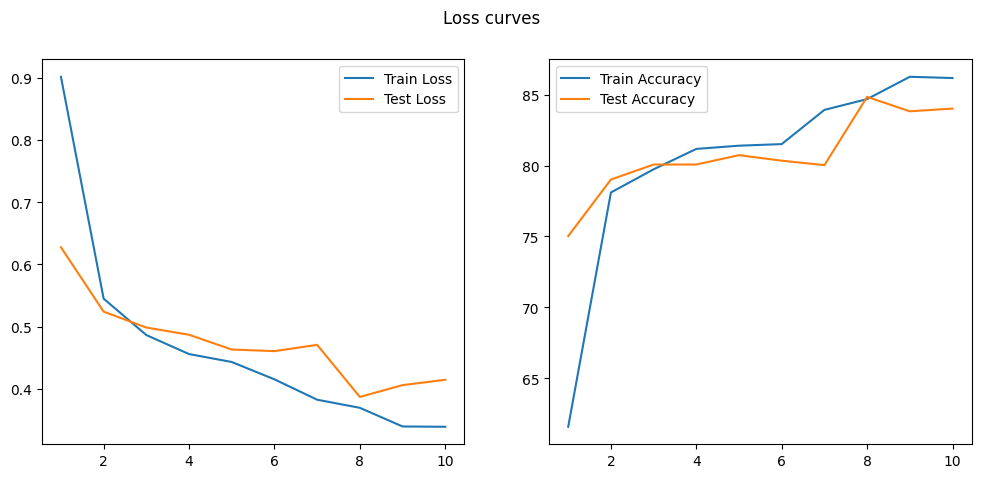

In [17]:
from plot_lib import plot_loss_curves

plot_loss_curves(epochs=results["Epoch"], train_loss=results["Train Loss"], test_loss= results["Test Loss"], train_acc=results["Train Accuracy"], test_acc= results["Test Accuracy"])

## Transfer Learning

### EfficientNetB0

#### With Adam Optimizer

In [19]:
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
model_2 = efficientnet_b0(weights = weights)

#summary(model_2, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20.5M/20.5M [00:00<00:00, 138MB/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       81.553919    0.601274      89.218750   0.334147
 1      2       89.446868    0.318813      89.687500   0.274409
 2      3       90.362200    0.265953      90.859375   0.250510
 3      4       91.440217    0.234475      90.625000   0.243676
 4      5       92.130292    0.224535      91.171875   0.233327
 5      6       92.425272    0.205857      91.718750   0.215194
 6      7       92.911542    0.193475      91.953125   0.209417
 7      8       93.170767    0.189260      91.562500   0.206681
 8      9       92.966962    0.198454      91.484375   0.209445
 9     10       92.945509    0.187609      91.406250   0.208561,
 None)

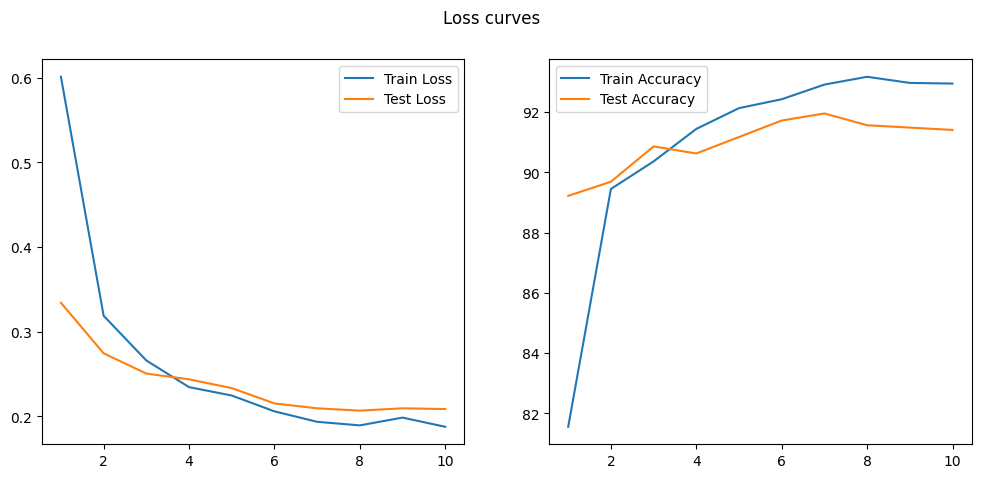

In [20]:
import train_model

weights = EfficientNet_B0_Weights.DEFAULT
model_2 = efficientnet_b0(weights = weights)


train_model.train_efficientnet(model = model_2,
                weights = weights,
                in_features = 1280,
                data_path = data_path,
                optimizer = 'adam',
                lr = 0.001,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

#### With SGD Optimizer

  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       84.214102    0.441395      90.078125   0.285202
 1      2       90.421196    0.268264      90.546875   0.243235
 2      3       91.449156    0.232329      90.625000   0.235485
 3      4       92.629076    0.204497      91.250000   0.225954
 4      5       92.537900    0.201563      90.625000   0.230834
 5      6       93.138587    0.188555      92.109375   0.205745
 6      7       93.240489    0.178178      92.031250   0.208428
 7      8       93.860841    0.174126      91.875000   0.206477
 8      9       93.329877    0.184325      91.328125   0.207171
 9     10       93.115346    0.181274      90.781250   0.211994,
 None)

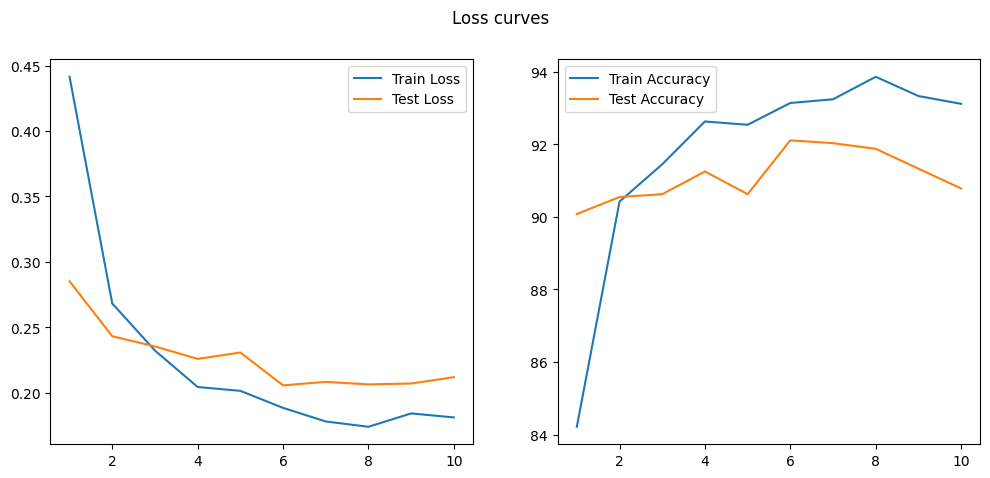

In [21]:
weights = EfficientNet_B0_Weights.DEFAULT
model_2 = efficientnet_b0(weights = weights)


train_model.train_efficientnet(model = model_2,
                weights = weights,
                in_features = 1280,
                data_path = data_path,
                optimizer = 'sgd',
                lr = 0.1,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

### EfficientNetB2

#### With Adam Optimizer

In [22]:
from torchvision.models import efficientnet_b2
from torchvision.models import EfficientNet_B2_Weights

weights = EfficientNet_B2_Weights.DEFAULT
model_3 = efficientnet_b2(weights = weights)

#summary(model_3, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 35.2M/35.2M [00:00<00:00, 165MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       82.290475    0.613817      91.015625   0.348212
 1      2       89.797268    0.319761      92.031250   0.262085
 2      3       90.805564    0.272090      92.500000   0.235855
 3      4       91.484911    0.243088      92.343750   0.221478
 4      5       91.835312    0.224261      91.953125   0.212298
 5      6       92.412757    0.203325      92.421875   0.209602
 6      7       92.820366    0.203256      92.656250   0.204315
 7      8       92.899027    0.194273      92.656250   0.200664
 8      9       93.648098    0.179942      92.734375   0.193624
 9     10       93.646310    0.184631      92.734375   0.195402,
 None)

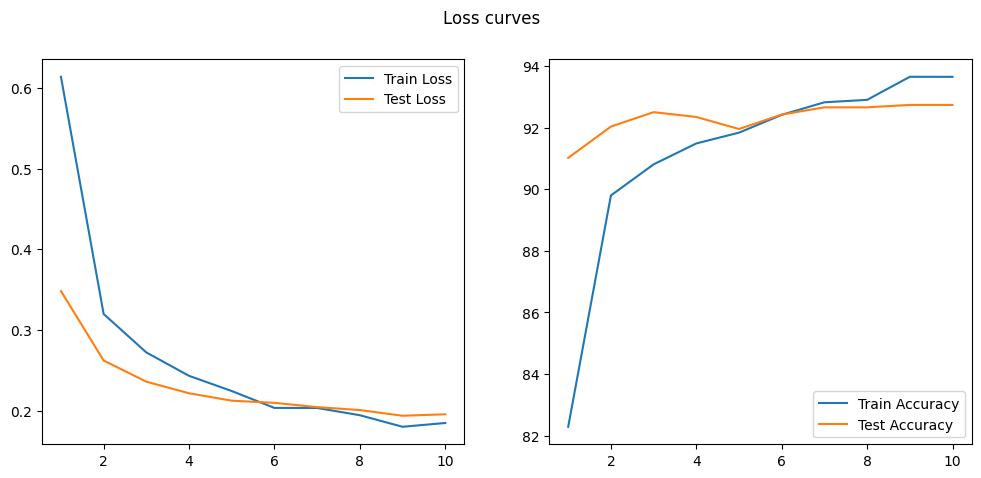

In [23]:
weights = EfficientNet_B2_Weights.DEFAULT
model_3 = efficientnet_b2(weights = weights)


train_model.train_efficientnet(model = model_3,
                weights = weights,
                in_features = 1408,
                optimizer = 'adam',
                lr = 0.001,
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

#### With SGD Optimizer

  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       84.644951    0.454519      91.875000   0.262024
 1      2       90.839531    0.263871      92.656250   0.223164
 2      3       91.236413    0.238658      93.046875   0.212661
 3      4       91.349042    0.218518      92.500000   0.206091
 4      5       92.266161    0.204857      92.265625   0.207737
 5      6       92.911542    0.187545      92.109375   0.201515
 6      7       93.170767    0.186899      92.578125   0.206943
 7      8       93.102832    0.185250      92.578125   0.200182
 8      9       94.066433    0.167952      92.890625   0.194261
 9     10       93.453232    0.175875      92.968750   0.192236,
 None)

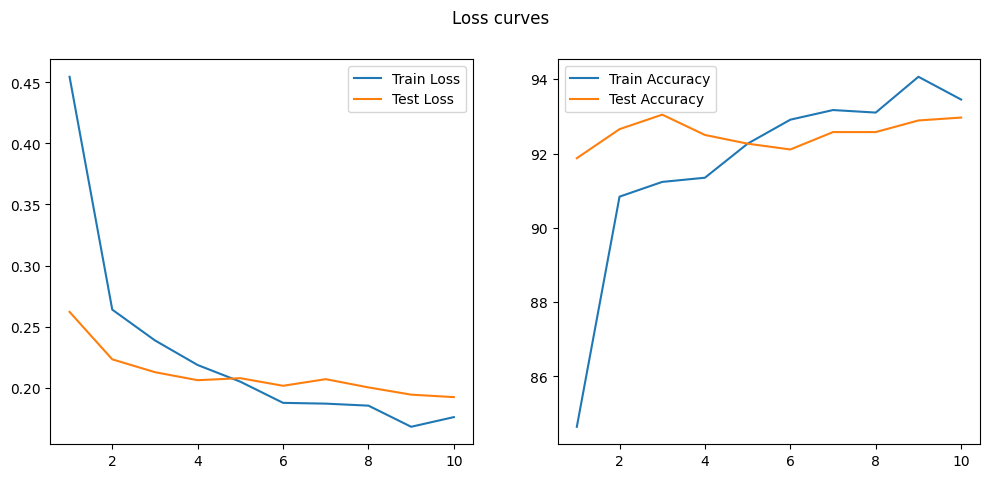

In [24]:
weights = EfficientNet_B2_Weights.DEFAULT
model_3 = efficientnet_b2(weights = weights)


train_model.train_efficientnet(model = model_3,
                weights = weights,
                in_features = 1408,
                optimizer = 'sgd',
                lr = 0.1,
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

### EfficientNetB3

#### With Adam Optimizer

In [25]:
from torchvision.models import efficientnet_b3
from torchvision.models import EfficientNet_B3_Weights

weights = EfficientNet_B3_Weights.DEFAULT
model_4 = efficientnet_b3(weights = weights)

#summary(model_4, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 47.2M/47.2M [00:00<00:00, 173MB/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       82.460312    1.543139      87.421875   1.016929
 1      2       88.166834    0.993058      88.671875   1.239454
 2      3       88.018450    1.285966      90.312500   1.129737
 3      4       89.096467    1.313357      88.906250   1.427251
 4      5       90.102975    1.276262      91.015625   1.293814
 5      6       90.385441    1.165195      90.000000   1.628502
 6      7       90.521310    1.354931      89.140625   1.995356
 7      8       90.591033    1.357682      89.140625   1.775591
 8      9       91.009368    1.390269      90.468750   1.801645
 9     10       92.300129    1.237663      90.703125   1.656916,
 None)

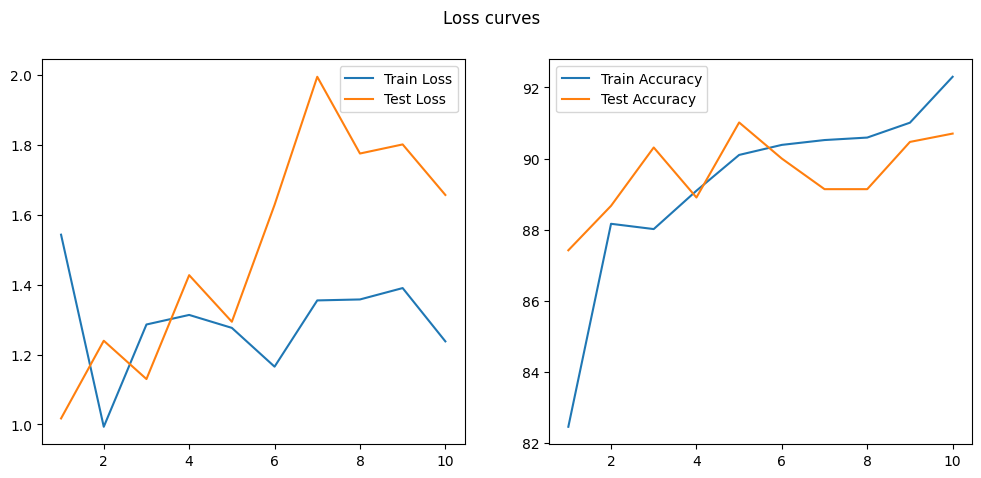

In [27]:
train_model.train_efficientnet(model = model_4,
                weights = weights,
                in_features = 1536,
                lr = 0.1,
                optimizer = 'adam',
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)
                

#### With SGD Optimizer

  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       82.131364    0.531204      88.828125   0.308251
 1      2       89.332451    0.308043      92.421875   0.253326
 2      3       90.748355    0.263191      91.796875   0.231117
 3      4       91.416977    0.244350      93.125000   0.218639
 4      5       91.935426    0.223795      92.812500   0.219928
 5      6       92.491419    0.217312      92.734375   0.211931
 6      7       92.198227    0.210022      93.281250   0.205086
 7      8       92.187500    0.202255      92.656250   0.205164
 8      9       94.145094    0.181481      92.968750   0.202915
 9     10       93.578375    0.184099      92.812500   0.208195,
 None)

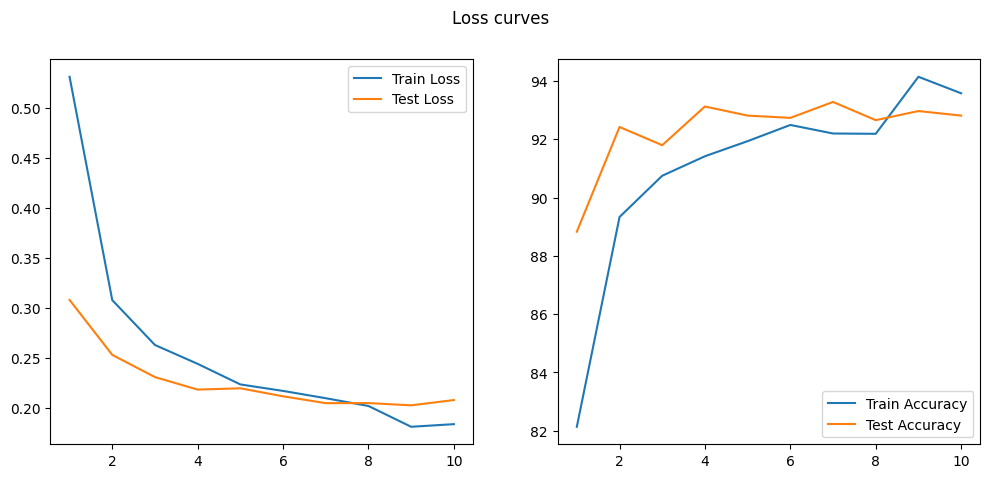

In [28]:
weights = EfficientNet_B3_Weights.DEFAULT
model_4 = efficientnet_b3(weights = weights)

train_model.train_efficientnet(model = model_4,
                weights = weights,
                in_features = 1536,
                lr = 0.1,
                optimizer = 'sgd',
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

### ResNet50

#### With Adam Optimizer

In [29]:
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
import train_model

weights = ResNet50_Weights.DEFAULT
model_5 = resnet50(weights = weights)
#summary(model_4, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 97.8M/97.8M [00:00<00:00, 187MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       80.751216    0.637772      89.331597   0.357548
 1      2       89.865203    0.329785      92.734375   0.269399
 2      3       91.484911    0.265573      94.218750   0.238444
 3      4       91.867491    0.243675      93.940972   0.217396
 4      5       92.809640    0.213689      93.862847   0.201544
 5      6       93.533681    0.197353      94.609375   0.192097
 6      7       94.179062    0.175814      94.019097   0.187013
 7      8       94.055707    0.169288      94.331597   0.180634
 8      9       94.202303    0.160912      94.253472   0.171772
 9     10       94.983553    0.148279      93.984375   0.174448,
 None)

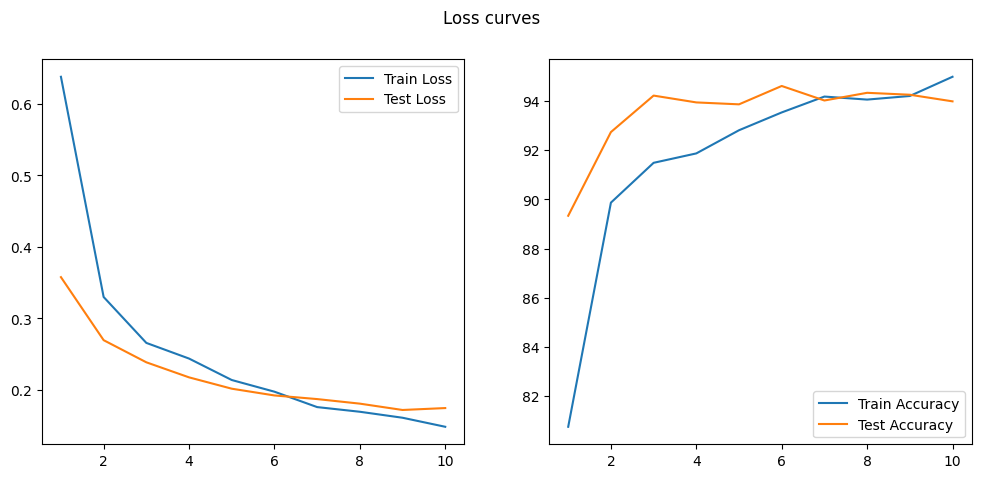

In [30]:
weights = ResNet50_Weights.DEFAULT
model_5 = resnet50(weights = weights)

train_model.train_resnet(model = model_5,
                weights = weights,
                in_features = 2048,
                optimizer = 'adam',
                lr = 0.001,
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

In [31]:
torch.save(obj = model_5.state_dict(), f = "Model/resnet50_10_epochs_adam_0_001.pth")

#### With SGD optimizer

  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       82.460312    0.502129      92.378472   0.272171
 1      2       89.784754    0.287727      93.750000   0.224240
 2      3       92.085598    0.233040      92.065972   0.213577
 3      4       92.457451    0.221898      94.140625   0.201733
 4      5       93.024170    0.198586      94.175347   0.184774
 5      6       93.669551    0.184783      93.472222   0.185019
 6      7       94.654605    0.165762      91.753472   0.213450
 7      8       94.531250    0.157146      93.628472   0.173161
 8      9       94.202303    0.154160      93.394097   0.174628
 9     10       95.017520    0.144502      93.750000   0.171306,
 None)

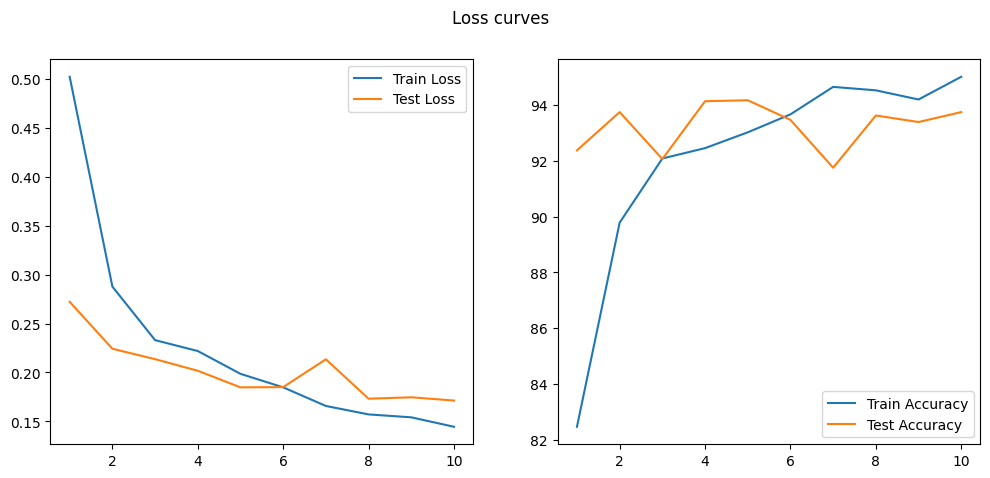

In [32]:
weights = ResNet50_Weights.DEFAULT
model_5 = resnet50(weights = weights)

train_model.train_resnet(model = model_5,
                weights = weights,
                in_features = 2048,
                optimizer = 'sgd',
                lr = 0.1,
                data_path = data_path,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

In [35]:
torch.save(obj = model_5.state_dict(), f = "Model/resnet50_10_epochs_sgd_0_1.pth")


## Testing Saved Model

Prediction: Healthy | Probability: 0.9864


(-0.5, 255.5, 255.5, -0.5)

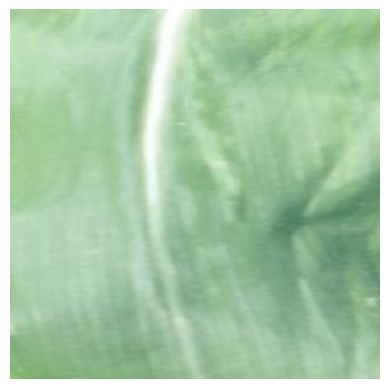

In [36]:
from predict import predict_single
import random


weights = ResNet50_Weights.DEFAULT
resnet_50 = resnet50(weights = weights)

for param in resnet_50.parameters():
    param.requires_grad = False

resnet_50.fc = nn.Sequential(
            nn.Dropout(p = 0.2, inplace = True),
            nn.Linear(in_features = 2048, out_features = len(classes), bias = True)
            )


resnet_50.load_state_dict(torch.load('Model/resnet50_10_epochs_adam_0_001.pth', weights_only=True))

labels = classes
image = random.choice(images_list)

pred, prob = predict_single(model = resnet_50, image = image, device = None, transform = weights.transforms(), labels = labels)

print(f"Prediction: {pred} | Probability: {prob:.4f}")
plt.imshow(Image.open(image))
plt.axis("off")

## Thank you üôè